imports

In [38]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

Read the csv

In [39]:
df = pd.read_csv('data/Combined_Less.csv', low_memory = False)

Drop the null values from the ABUND column

In [40]:
df_filtered = df.dropna(subset=['ABUND'])
#df_filtered.head()

Output the total count of each Common_Name. This is used to determine which fish we want to analyze

In [41]:
common_name_counts = df_filtered['Common_Name'].value_counts()
tot_count_per_name = df_filtered.groupby('Common_Name')['TotCount'].sum()
for common_name in common_name_counts.index:
    count = common_name_counts[common_name]
    tot_count = tot_count_per_name[common_name]
    print(f"{common_name}: {count} rows, Total TotCount: {tot_count}")

Bluntnose Minnow: 635 rows, Total TotCount: 490969.0
Central Stoneroller: 626 rows, Total TotCount: 519771.0
Creek Chub: 587 rows, Total TotCount: 477189.0
Northern Hog Sucker: 586 rows, Total TotCount: 456642.0
White Sucker: 552 rows, Total TotCount: 444290.0
Bluegill Sunfish: 544 rows, Total TotCount: 394950.0
Johnny Darter: 518 rows, Total TotCount: 424371.0
Fantail Darter: 508 rows, Total TotCount: 435741.0
Striped Shiner: 484 rows, Total TotCount: 408426.0
Green Sunfish: 480 rows, Total TotCount: 350796.0
Greenside Darter: 459 rows, Total TotCount: 394316.0
Rock Bass: 437 rows, Total TotCount: 333059.0
Golden Redhorse: 410 rows, Total TotCount: 305694.0
Rainbow Darter: 405 rows, Total TotCount: 381631.0
Spotfin Shiner: 380 rows, Total TotCount: 285265.0
Smallmouth Bass: 371 rows, Total TotCount: 301199.0
Western Blacknose Dace: 367 rows, Total TotCount: 332008.0
Silverjaw Minnow: 359 rows, Total TotCount: 329197.0
Sand Shiner: 341 rows, Total TotCount: 270236.0
Largemouth Bass: 33

We ended up choosing a Bluntnose Minnow. Since this is a baitfish (prey), we include a total count of the below list of predatory fish (I provided ChatGPT with a list of the common names, and it output the most likely fish to eat the Broadnose minnow. We add this count as a new column called pred_count

In [42]:
Predators = ['Rock Bass',
'Smallmouth Bass',
'Largemouth Bass',
'Northern Pike',
'Flathead Catfish',
'Yellow Perch',
'Pumpkinseed Sunfish',
'Black Crappie',
'Orangespotted Sunfish',
'Redear Sunfish',
'Spotted Bass',
'Longnose Gar',
'Bowfin',
'Channel Catfish',
'Freshwater Drum',
'Walleye',
'Sauger',
'Muskellunge',
'Brown Trout',
'Rainbow Trout',
'Brook Trout',
'Chain Pickerel',
'Striped Bass',
'Blue Sucker',
'Shortnose Gar']
predatory_fish_df = df_filtered[df_filtered['Common_Name'].isin(Predators)]
pred_count_df = predatory_fish_df.groupby('Station_Date')['ABUND'].sum().reset_index()
pred_count_df.rename(columns={'ABUND': 'pred_count'}, inplace=True)
fish_df = df_filtered.merge(pred_count_df, on='Station_Date', how='left')
fish_df['pred_count'].fillna(0, inplace=True)

Very similar to the above created pred_count column, we create an additioinal column called comp_count which holds the count of species observed that are in direct competition with our bluntnose minnow.

In [43]:
Competitors = [
    "Central Stoneroller",
    "Creek Chub",
    "Johnny Darter",
    "Fantail Darter",
    "Striped Shiner",
    "Green Sunfish",
    "Greenside Darter",
    "Rainbow Darter",
    "Spotfin Shiner",
    "Western Blacknose Dace",
    "Silverjaw Minnow",
    "Sand Shiner",
    "Logperch",
    "Banded Darter",
    "Longear Sunfish",
    "Silver Shiner",
    "Rosyface Shiner",
    "Blackside Darter",
    "Mimic Shiner",
    "Emerald Shiner",
    "South. Redbelly Dace",
    "Orangethroat Darter",
    "Scarlet Shiner",
    "Variegate Darter",
    "Pumpkinseed Sunfish",
    "Trout-Perch",
    "Bigeye Chub",
    "Brook Silverside",
    "Common Shiner",
    "Redside Dace",
    "Suckermouth Minnow",
    "Bluebreast Darter",
    "Dusky Darter",
    "Bullhead Minnow",
    "Redfin Shiner",
    "Gravel Chub",
    "Streamline Chub",
    "Steelcolor Shiner",
    "Fathead Minnow",
    "Eastern Sand Darter",
    "Rosyside Dace",
    "Slenderhead Darter",
    "Orangespotted Sunfish",
    "Blackstripe Topminnow",
    "Longnose Dace",
    "Northern Studfish",
    "Bigeye Shiner",
    "Spotted Darter",
    "River Shiner",
    "Channel Shiner",
    "Ghost Shiner"
]
competitor_fish_df = fish_df[fish_df['Common_Name'].isin(Competitors)]
comp_count_df = competitor_fish_df.groupby('Station_Date')['ABUND'].sum().reset_index()
comp_count_df.rename(columns={'ABUND': 'comp_count'}, inplace=True)
fish_df = fish_df.merge(comp_count_df, on='Station_Date', how='left')
fish_df['comp_count'].fillna(0, inplace=True)

In [44]:
species_count_per_station = fish_df.groupby('Station_Date')['species'].nunique()
fish_df['spec_count'] = fish_df['Station_Date'].map(species_count_per_station)

In [45]:
fish_df.head()

,species,state,HUCName,Common_Name,Dataset,Station_Date,SITE_ID,YEAR,month,ECOREGL3,...,k,hco3,tn,al,Se,Cadmium,Calcium,pred_count,comp_count,spec_count
0,Ambloplites rupestris,OH,NaN,Rock Bass,OH,200282_38909,200282,2006,8,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,514.0,17
1,Campostoma anomalum,OH,NaN,Central Stoneroller,OH,200282_38909,200282,2006,8,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,514.0,17
2,Catostomus commersonii,OH,NaN,White Sucker,OH,200282_38909,200282,2006,8,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,514.0,17
3,Chrosomus erythrogaster,OH,NaN,South. Redbelly Dace,OH,200282_38909,200282,2006,8,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,514.0,17
4,Clinostomus funduloides,OH,NaN,Rosyside Dace,OH,200282_38909,200282,2006,8,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,514.0,17


Determine our target fish and only retain rows with this common name. We chose this fish because it has the most records available.

In [46]:
selected_fish = 'Bluntnose Minnow'
fish_df = fish_df[fish_df['Common_Name'] == selected_fish].copy()
#fish_df.head()

Determine if any columns are constants meaning the same value is present in all columns. These columns will be dropped from the df

In [47]:
constant_columns = [col for col in fish_df.columns if fish_df[col].nunique() <= 1]
print("Constant Columns:", constant_columns)

Constant Columns: ['species', 'state', 'Common_Name', 'Dataset', 'ECOREGL3', 'BigHUC', 'FE', 'MN', 'TP', 'do', 'Temp', 'GENUS', 'NUMSPEC', 'NSBENT_INV', 'NSBENT_INV_NONTOL', 'NSINTOL', 'PINTOL', 'PBENT_INV', 'PBENT_INV_NONTOL', 'abent_inv', 'abent_inv_nontol', 'aintol', 'ns_DarScuMad', 'ab_DarScuMad', 'p_DarScuMad', 'FOR_TOT', 'hardness', 'Fecal_Coliform', 'xembed', 'pct_safn', 'al', 'Se', 'Cadmium', 'Calcium']


drop these columns as well as the SUMCOUNT column because it is the exact same as the TotCount. For now, we only want to work with the numerical values.

In [48]:
fish_df = fish_df.drop(columns=constant_columns)
fish_df = fish_df.drop(columns=['SUMCOUNT'])

In [49]:
textual_columns = fish_df.select_dtypes(include = ['object']).copy()
for col in textual_columns.columns:
    unique_values = textual_columns[col].nunique()
    print(f"Column '{col}' has {unique_values} unique values")

Column 'HUCName' has 208 unique values
Column 'Station_Date' has 635 unique values
Column 'SITE_ID' has 485 unique values
Column 'Station_Year' has 494 unique values


After seeing that the only textual columns that aren't constants are the above, I decided to exclude them from my analysis 

In [50]:
numerical_df = fish_df.select_dtypes(include=[np.number])

In [51]:
null_percentage = numerical_df.isnull().mean() * 100
for column, percentage in null_percentage.items():
    print(f"{column}: {percentage:.2f}%")

YEAR: 0.00%
month: 0.00%
LAT_DD: 0.00%
LON_DD: 0.00%
HUC: 0.00%
PHSTVL: 0.00%
COND: 0.00%
CA: 4.25%
SO4: 11.02%
NO3: 4.09%
CL: 4.09%
alk: 11.18%
rbpscore: 55.75%
ABUND: 0.00%
WS_AREA: 0.00%
LWSKM2: 0.00%
lcond: 0.00%
SO4HCO3: 11.18%
ratio: 11.18%
TotCount: 0.00%
RA: 0.00%
VISIT_NO: 0.00%
num: 0.00%
mg: 4.88%
na: 4.25%
k: 4.25%
hco3: 11.18%
tn: 4.09%
pred_count: 0.00%
comp_count: 0.00%
spec_count: 0.00%


drop the rbpscore column as it has a large number of missing values

In [52]:
numerical_df = numerical_df.drop(columns = ['rbpscore'])

determine the percentage of values per column that show outliers using the IQR technique. 

In [53]:
outlier_info = {}
for column in numerical_df.select_dtypes(include=[np.number]).columns:
    Q1 = numerical_df[column].quantile(0.25)
    Q3 = numerical_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = numerical_df[(numerical_df[column] < lower_bound) | (numerical_df[column] > upper_bound)][column]
    outlier_percentage = (len(outliers) / len(df)) * 100
    outlier_info[column] = outlier_percentage

Print out each null percentage and the outlier percentage for each column

In [54]:
for column in numerical_df.columns:
    if column in outlier_info:
        print(f"{column}: Null Percentage = {null_percentage[column]:.2f}%, Outlier Percentage = {outlier_info[column]:.2f}%")
    else:
        print(f"{column}: Null Percentage = {null_percentage[column]:.2f}%")

YEAR: Null Percentage = 0.00%, Outlier Percentage = 0.04%
month: Null Percentage = 0.00%, Outlier Percentage = 0.13%
LAT_DD: Null Percentage = 0.00%, Outlier Percentage = 0.00%
LON_DD: Null Percentage = 0.00%, Outlier Percentage = 0.00%
HUC: Null Percentage = 0.00%, Outlier Percentage = 0.00%
PHSTVL: Null Percentage = 0.00%, Outlier Percentage = 0.03%
COND: Null Percentage = 0.00%, Outlier Percentage = 0.12%
CA: Null Percentage = 4.25%, Outlier Percentage = 0.10%
SO4: Null Percentage = 11.02%, Outlier Percentage = 0.14%
NO3: Null Percentage = 4.09%, Outlier Percentage = 0.14%
CL: Null Percentage = 4.09%, Outlier Percentage = 0.10%
alk: Null Percentage = 11.18%, Outlier Percentage = 0.00%
ABUND: Null Percentage = 0.00%, Outlier Percentage = 0.12%
WS_AREA: Null Percentage = 0.00%, Outlier Percentage = 0.21%
LWSKM2: Null Percentage = 0.00%, Outlier Percentage = 0.02%
lcond: Null Percentage = 0.00%, Outlier Percentage = 0.02%
SO4HCO3: Null Percentage = 11.18%, Outlier Percentage = 0.12%
ra

Since we don't have any columns with a high percentage of outliers, we can impute the missing values by the mean rather than the median

In [55]:
numerical_df = numerical_df.fillna(numerical_df.mean())

Let's see the distribution of TotCount. It's right-skewed which is to be expected. In ecological datasets, it's common to see the distribution skewed to the right. This is because if a population is smaller than a certain number, it's unlikely that the population lived and reproduced enough to be counted in our dataset. Basically, the fewer members of a species exists in a given area, the more likely that they will be driven to extinction in that area either due to natural or man-made reasons.

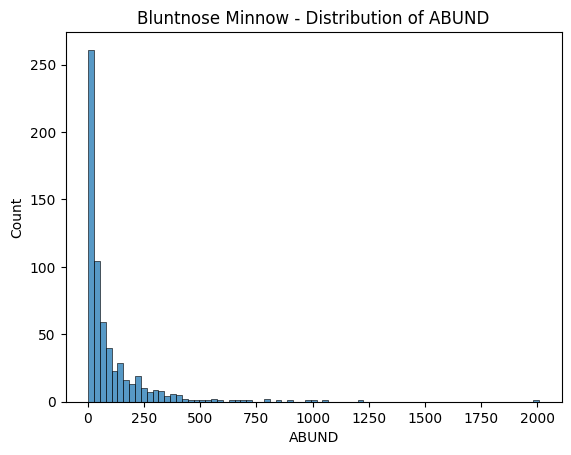

In [56]:
sns.histplot(numerical_df['ABUND'])
plt.title(f'{selected_fish} - Distribution of ABUND')
plt.show()

Let's make a correlation matrix. When considering ABUND, a few correlations stick out. TotCount and RA (Relative Abundance) have a high correlation with our chosen feature. This is to be expected as TotCount is the total count of all fish specimens within an observation, and RA is the percentage value that our ABUND is of the TotCount. These columns need to be removed to avoid multicollinearity.

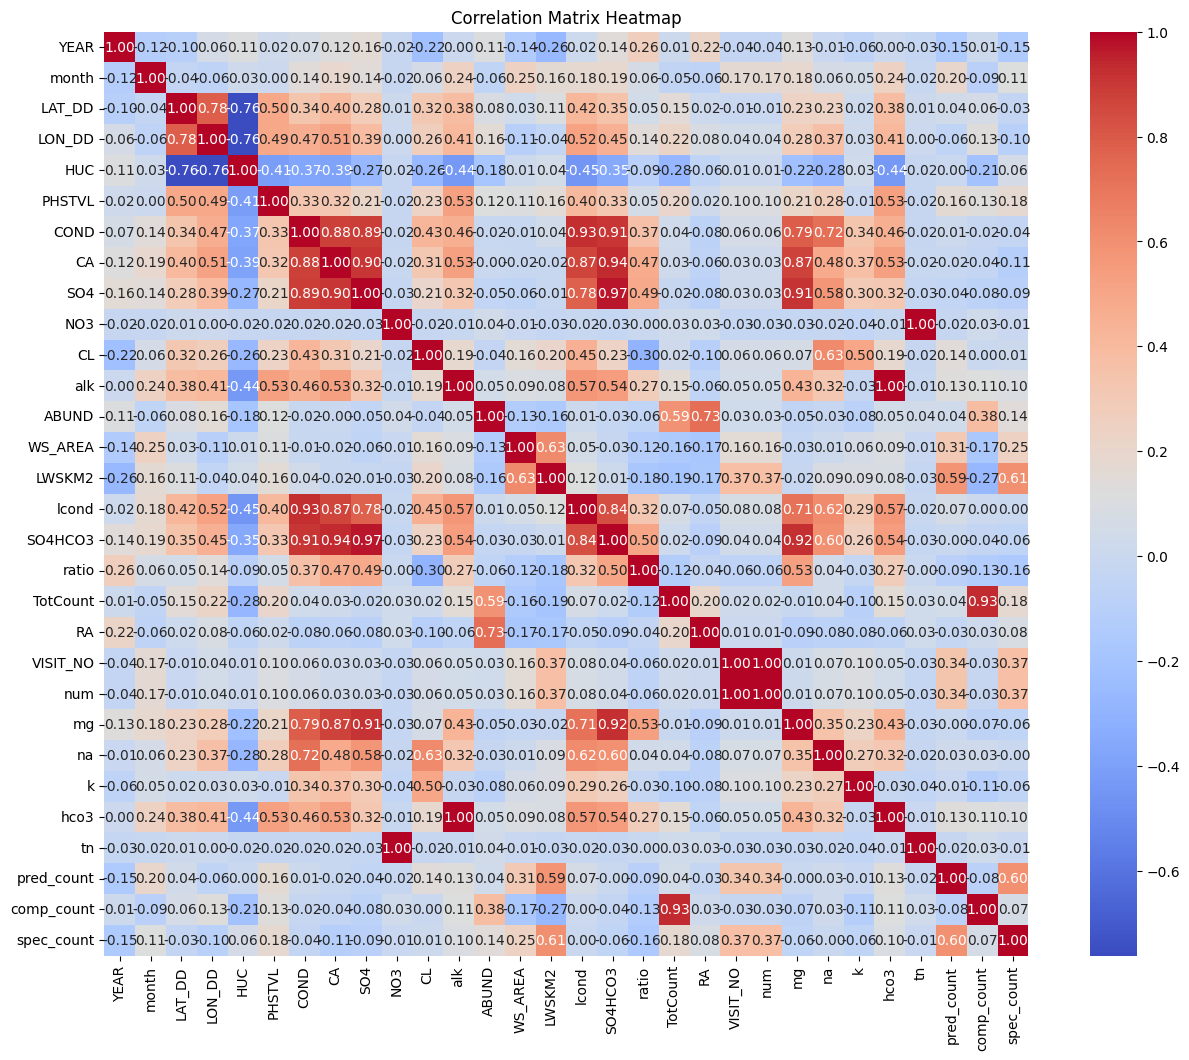

In [57]:
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

dropping these columns as well as num since it's a helper column used to determine the visit number per the documentation

In [58]:
numerical_df = numerical_df.drop(columns = ['TotCount', 'RA', 'num'])

In [59]:
print(numerical_df.columns)

Index(['YEAR', 'month', 'LAT_DD', 'LON_DD', 'HUC', 'PHSTVL', 'COND', 'CA',
       'SO4', 'NO3', 'CL', 'alk', 'ABUND', 'WS_AREA', 'LWSKM2', 'lcond',
       'SO4HCO3', 'ratio', 'VISIT_NO', 'mg', 'na', 'k', 'hco3', 'tn',
       'pred_count', 'comp_count', 'spec_count'],
      dtype='object')


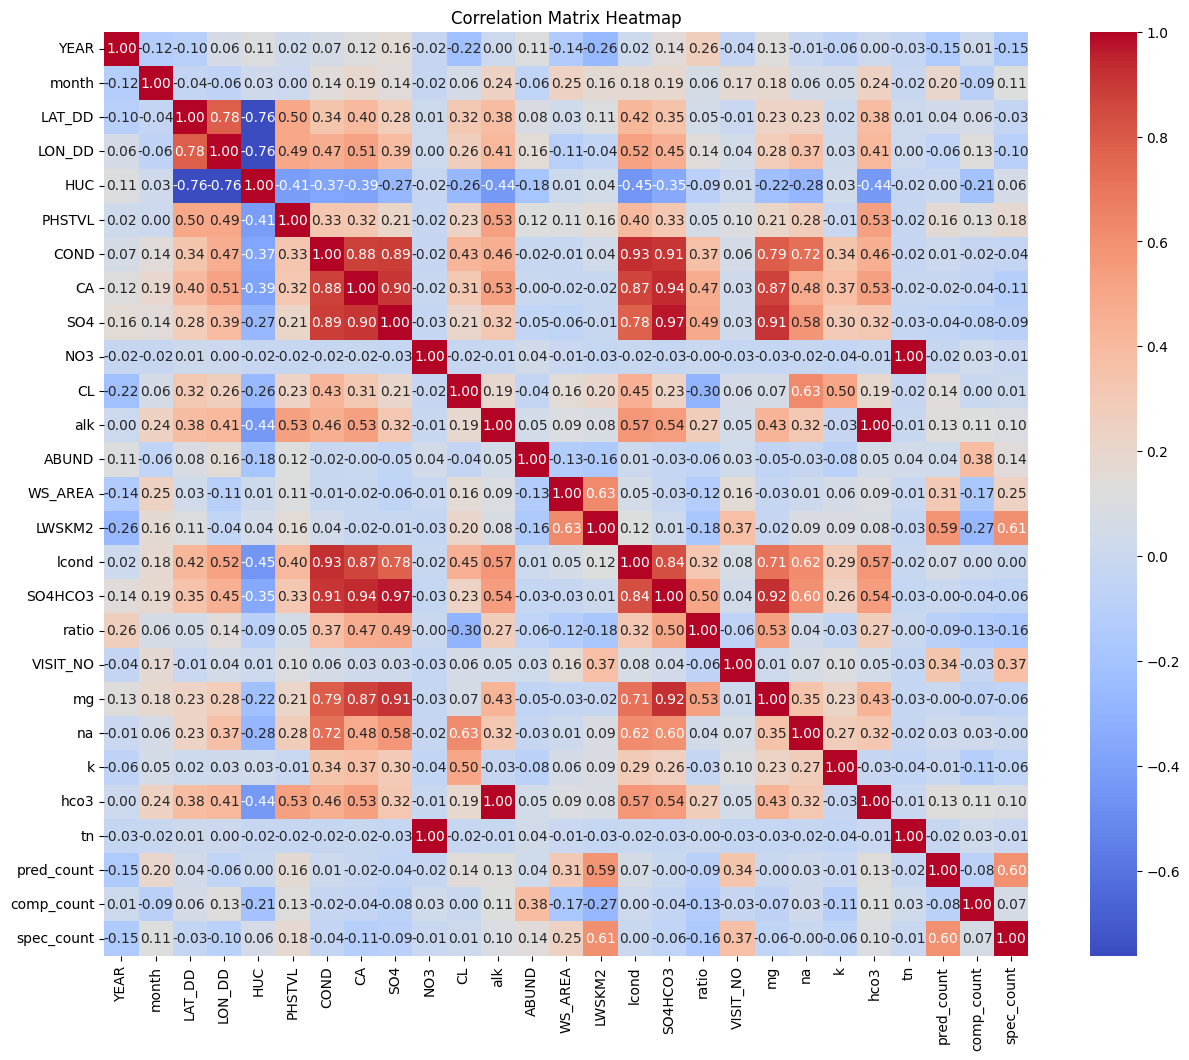

In [60]:
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [61]:
ABUND_Count = correlation_matrix['ABUND'].sort_values(ascending=False)
print(ABUND_Count)

ABUND         1.000000
comp_count    0.380467
LON_DD        0.155184
spec_count    0.139515
PHSTVL        0.115283
YEAR          0.105195
LAT_DD        0.084523
alk           0.049885
hco3          0.049763
NO3           0.042483
tn            0.042127
pred_count    0.035542
VISIT_NO      0.029929
lcond         0.011273
CA           -0.000433
COND         -0.018859
na           -0.025746
SO4HCO3      -0.028035
CL           -0.037870
SO4          -0.045941
mg           -0.052400
month        -0.056613
ratio        -0.059060
k            -0.083207
WS_AREA      -0.129196
LWSKM2       -0.156055
HUC          -0.184641
Name: ABUND, dtype: float64


Even though the correlation values are very small, let's set up our linear regression to begin with. We start by splitting the dataset into training and testing sections, scaling them to an appropriate range, and initializing our model

In [62]:
X = numerical_df.drop(columns=['ABUND'])
y = numerical_df['ABUND']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LinearRegression()

let's train the model

In [63]:
model.fit(X_train_scaled, y_train)

LinearRegression()

That's what we expected to see. Our misses are large misses and our linear regression only explains roughly 17% of the data variance. We will move on to a random forest to see if we can predict more accurately.

In [64]:
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 15984.61920726521
R-squared: 0.17414714098339545


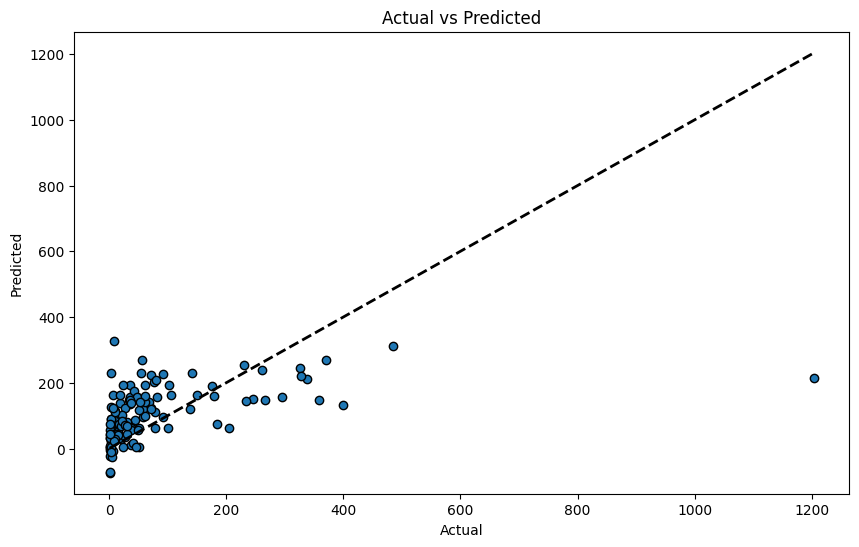

In [65]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

Let's go through the same steps as above except we are going to use a random forest regression instead of a linear regression. If the relationship between the X and Y values is not strictly linear, we can expect more appropriate scores from this model

In [66]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R-squared:", r2_rf)

Random Forest Mean Squared Error: 18227.566881889765
Random Forest R-squared: 0.05826419590382681


In [67]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature comp_count (0.4004537026096253)
2. feature pred_count (0.05178327413354326)
3. feature SO4 (0.05053150943012261)
4. feature PHSTVL (0.044678378168528245)
5. feature LAT_DD (0.04356081286773368)
6. feature LON_DD (0.03961748402039754)
7. feature NO3 (0.032987457689724616)
8. feature spec_count (0.031118787081937292)
9. feature ratio (0.030396204574523134)
10. feature CA (0.028308776565412537)
11. feature na (0.02377623011156403)
12. feature LWSKM2 (0.023578403882806624)
13. feature CL (0.021605915496285624)
14. feature k (0.020533816041960872)
15. feature YEAR (0.020065404460289312)
16. feature WS_AREA (0.019763817474393913)
17. feature tn (0.017918752598676826)
18. feature month (0.01741670774476839)
19. feature mg (0.016884940316396587)
20. feature alk (0.014076353887787413)
21. feature hco3 (0.012616251223289368)
22. feature SO4HCO3 (0.011855135135288294)
23. feature COND (0.00956761780406663)
24. feature VISIT_NO (0.007772652815413645)
25. feature lcond (

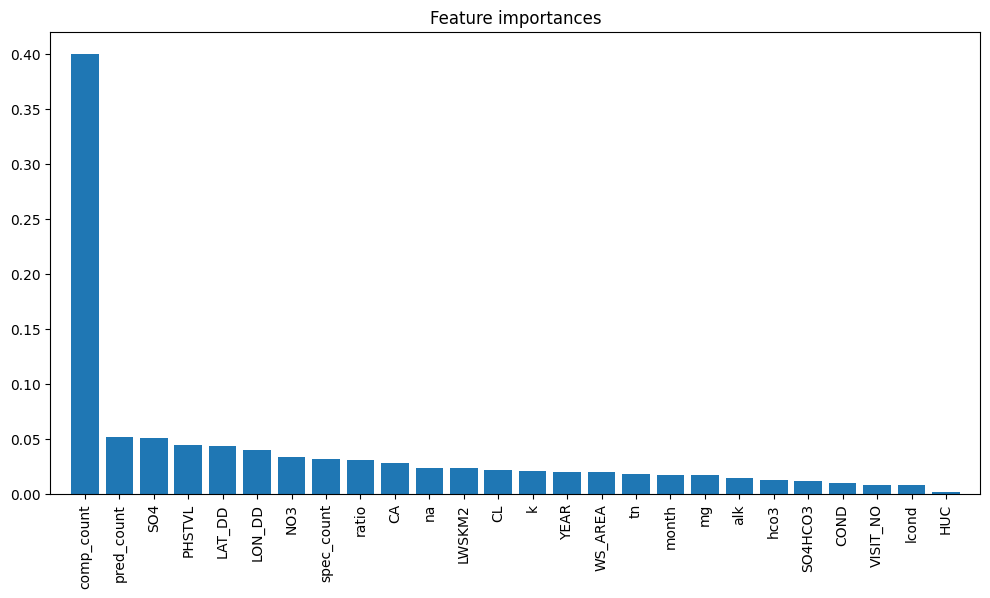

In [68]:
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

This shows the slight relationship between our Abundance of the selected fish and the total number of predatory fish observed within that observation

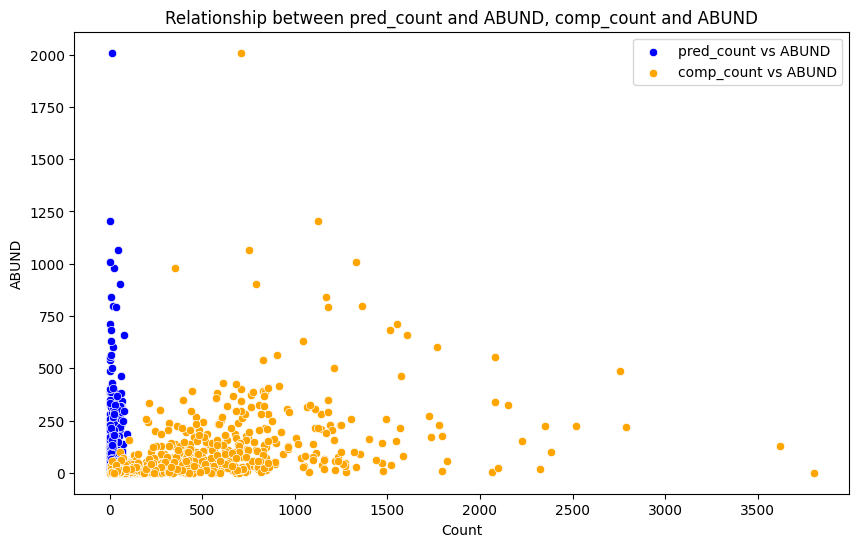

In [71]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fish_df['pred_count'], y=fish_df['ABUND'], label='pred_count vs ABUND', color='blue')
sns.scatterplot(x=fish_df['comp_count'], y=fish_df['ABUND'], label='comp_count vs ABUND', color='orange')
plt.xlabel('Count')
plt.ylabel('ABUND')
plt.title('Relationship between pred_count and ABUND, comp_count and ABUND')
plt.legend()
plt.show()

checking for mulivollinearity using VIF

In [73]:
#X = fish_df.drop(columns=['ABUND'])
#X['Intercept'] = 1  # Add intercept for VIF calculation
#vif = pd.DataFrame()
#vif['Variable'] = X.columns
#vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#print(vif)